# Сравнение эффективности операции удаления элемента в структурах данных

## Подготовка данных

Чтобы получить качественные результаты, следует протестировать наши структуры на разных данных. Сначала сгенерируем несколько файлов с разным кол-вом слов (половину файлов с несортированными данными и половину с отсортированными)

In [68]:
import string
import random
import numpy as np
import pandas as pd
import subprocess
import os
import matplotlib.pyplot as plt

In [69]:
def gen_text(words_count, word_len=10, sort=False):
    return ' '.join((sorted if sort else lambda x: x)(''.join(random.choices(string.ascii_letters, k=word_len)) for _ in range(words_count)))


In [70]:
FILES_DIR = './files'

wcs = list(map(round, np.geomspace(10, 10000, 20)))

for wc in wcs:
    with open(f'{FILES_DIR}/{wc}.txt', 'w') as f:
        f.write(gen_text(wc))

    with open(f'{FILES_DIR}/{wc}s.txt', 'w') as f:
        f.write(gen_text(wc, sort=True))

## Подготовка к тестированию

Заведём датафреймы для хранения результатов

In [71]:
structures = ['file', 'hash-table', 'tree', 'avl-tree']
time_res_unsorted_df = pd.DataFrame(columns=structures, index=wcs)
time_res_sorted_df = pd.DataFrame(columns=structures, index=wcs)
comps_res_unsorted_df = pd.DataFrame(columns=structures, index=wcs)
comps_res_sorted_df = pd.DataFrame(columns=structures, index=wcs)
mem_res_unsorted_df = pd.DataFrame(columns=structures, index=wcs)
mem_res_sorted_df = pd.DataFrame(columns=structures, index=wcs)

## Тестирование времени и сравнений

In [72]:
def test_time_and_comps(struct_name, filename, iterations=1):
    total_time = 0
    total_comps = 0

    for _ in range(iterations):
        # Запускаем программу, чтобы протестировать и получить время выполнения удаления случайного элемента и кол-во сравнений
        result = subprocess.run(['./main', filename, struct_name], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        time = float(result.stdout.decode('utf8').split()[1])
        comps = float(result.stdout.decode('utf8').split()[3])

        total_time += time
        total_comps += comps

    return total_time / iterations, total_comps / iterations  # Возвращаем пару среднего времени и среднего кол-ва сравнений

In [73]:
ITERS = 100  # Сколько раз будем тестировать один файл на каждой структуре

for wc in wcs:  # Итерируемся по всем сгенерированным текстам (по кол-вам слов)
    for struct in structures:
        # Для несортированных
        time, comps = test_time_and_comps(struct, f'{FILES_DIR}/{wc}.txt', ITERS)
        time_res_unsorted_df.loc[wc, struct] = time
        comps_res_unsorted_df.loc[wc, struct] = comps

        # Для сортированных
        time, comps = test_time_and_comps(struct, f'{FILES_DIR}/{wc}s.txt', ITERS)
        time_res_sorted_df.loc[wc, struct] = time
        comps_res_sorted_df.loc[wc, struct] = comps

## Тестирование памяти
Будем использовать *Valgrid* с инструментом `massif`. *Valgrid* сам сделает несколько итераций и сложит результаты в один файл. Нам останется прочитать данные с файлов и обработать их.

In [74]:
def test_valgrid_massif(struct_name, filename):
    subprocess.run(['valgrind', '--tool=massif', './main', filename, struct_name], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    massif_file = None
    for file in os.listdir('.'):
        if file.startswith('massif'):
            massif_file = file

    if not massif_file:
        return np.nan

    total = 0
    count = 0

    with open(massif_file) as res:
        for line in res.readlines():
            if line.startswith('mem_heap_B'):
                count += 1
                total += int(line.split('=')[1])

    os.remove(massif_file)
            
    return round(total / count, 3)

In [75]:
for wc in wcs:
    for struct in structures:
        mem = test_valgrid_massif(struct, f'{FILES_DIR}/{wc}.txt')
        mem_res_unsorted_df.loc[wc, struct] = mem

        mem = test_valgrid_massif(struct, f'{FILES_DIR}/{wc}s.txt')
        mem_res_sorted_df.loc[wc, struct] = mem

In [76]:
# Т.к. измеряется память всей программы целиком, примем за 0 память, которую потребляет "файл"

mem_res_unsorted_df = mem_res_unsorted_df.apply(lambda x: x - x['file'], axis=1)
mem_res_sorted_df = mem_res_sorted_df.apply(lambda x: x - x['file'], axis=1)

## Итоги
Построим графики для каждой метрики

Text(0.5, 1.0, 'Time spent for deletion (sorted)')

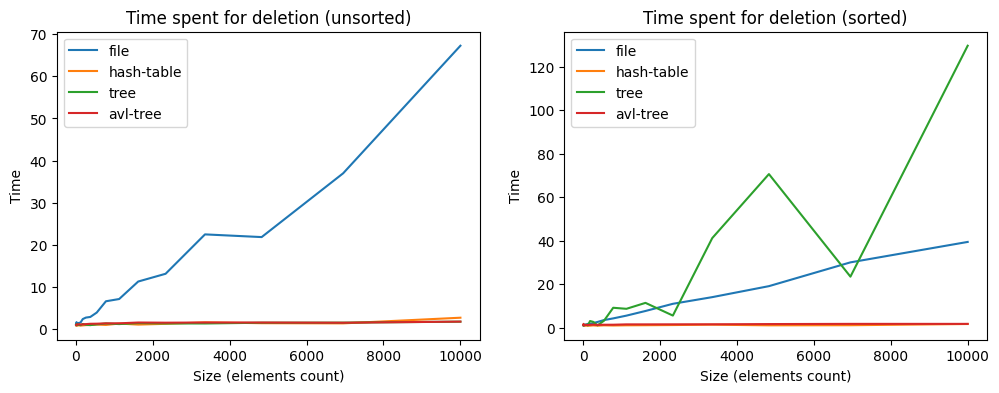

In [77]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(time_res_unsorted_df)
plt.legend(structures)
plt.xlabel('Size (elements count)')
plt.ylabel('Time')
plt.title('Time spent for deletion (unsorted)')

plt.subplot(1, 2, 2)
plt.plot(time_res_sorted_df)
plt.legend(structures)
plt.xlabel('Size (elements count)')
plt.ylabel('Time')
plt.title('Time spent for deletion (sorted)')

Text(0.5, 1.0, 'Memory use for deletion (sorted)')

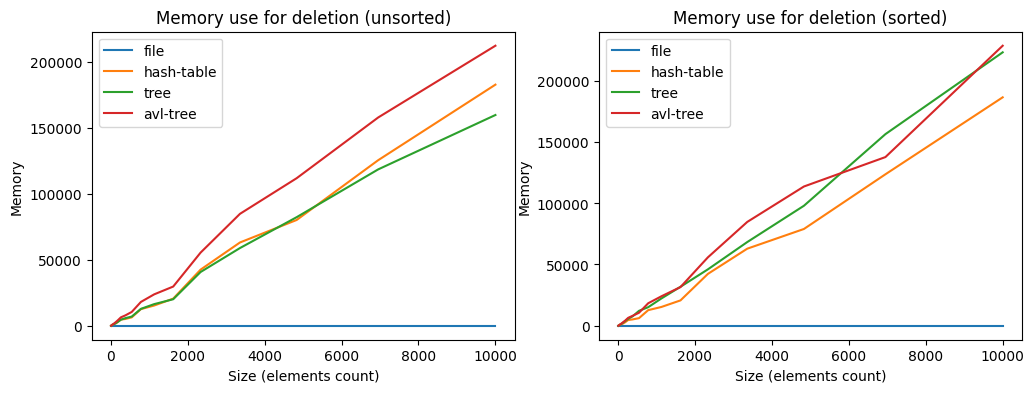

In [78]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(mem_res_unsorted_df)
plt.legend(structures)
plt.xlabel('Size (elements count)')
plt.ylabel('Memory')
plt.title('Memory use for deletion (unsorted)')

plt.subplot(1, 2, 2)
plt.plot(mem_res_sorted_df)
plt.legend(structures)
plt.xlabel('Size (elements count)')
plt.ylabel('Memory')
plt.title('Memory use for deletion (sorted)')

Text(0.5, 1.0, 'Comaprisons need for deletion (sorted)')

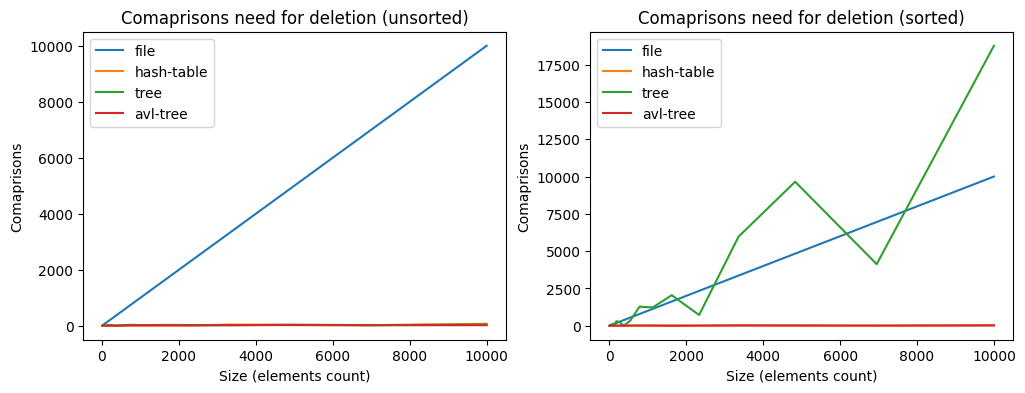

In [79]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(comps_res_unsorted_df)
plt.legend(structures)
plt.xlabel('Size (elements count)')
plt.ylabel('Comaprisons')
plt.title('Comaprisons need for deletion (unsorted)')

plt.subplot(1, 2, 2)
plt.plot(comps_res_sorted_df)
plt.legend(structures)
plt.xlabel('Size (elements count)')
plt.ylabel('Comaprisons')
plt.title('Comaprisons need for deletion (sorted)')

Сделаем также сводную табличку со средними значениями по размерностям

In [80]:
average_unsorted_res = pd.DataFrame(columns=['time', 'memory', 'comparisons'], index=structures)
average_sorted_res = pd.DataFrame(columns=['time', 'memory', 'comparisons'], index=structures)

for struct in structures:
    average_unsorted_res.loc[struct] = time_res_unsorted_df[struct].mean(), mem_res_unsorted_df[struct].mean(), comps_res_unsorted_df[struct].mean() 
    average_sorted_res.loc[struct] = time_res_sorted_df[struct].mean(), mem_res_sorted_df[struct].mean(), comps_res_sorted_df[struct].mean() 

In [81]:
average_unsorted_res

,time,memory,comparisons
file,10.503,0.0,1639.35
hash-table,1.1795,28259.61265,10.3
tree,1.2375,26649.63605,18.1
avl-tree,1.333,36406.0024,11.8


In [82]:
average_sorted_res

,time,memory,comparisons
file,7.5565,0.0,1639.35
hash-table,1.0815,28310.46875,6.2
tree,15.92,34778.50805,2245.2
avl-tree,1.389,36516.3378,9.5
